## NIPS SCM Spin Test 

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-04-25 17:21:02.943612: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 17:21:04.546050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 17:21:06.344382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import importlib
import data

import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
from models import *
from data import * 
from sim import *

import models
import models.metrics
from models.metrics import *

from sim.null import fit_scm, fit_scm_closed, fit_scm_closed_with_scalar_bias, fit_scm_closed_with_gcv, grid_search_alpha_with_gcv
from sim.null import get_best_pls_model


## Specify connectome and transcriptome

Assign features and targets

In [5]:
# S400
X = load_transcriptome(parcellation='S400', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
X_pca = load_transcriptome(parcellation='S400', run_PCA=True, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=False, measure='SC', hemisphere='both', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=False, measure='FC', hemisphere='both', include_labels=True)
Y = Y_fc
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]
X_pca = X_pca[valid_indices]
Y = Y[valid_indices][:, valid_indices]


Number of components for 95% variance PCA: 27


## Find Best True Fit SCM model

alpha=0      | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=1e-05  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.0001 | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.001  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.01 | Tr(H)=728.99
alpha=0.01   | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.06 | Tr(H)=728.94
alpha=0.1    | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.65 | Tr(H)=728.35
alpha=1      | GCV=1.1321e-07 | Residual=6.9415e+01 | τ=206302.44 | Tr(H)=722.56
alpha=10     | GCV=1.1332e-07 | Residual=6.9465e+01 | τ=206355.23 | Tr(H)=669.77
alpha=100    | GCV=1.1874e-07 | Residual=7.1201e+01 | τ=206630.65 | Tr(H)=394.35


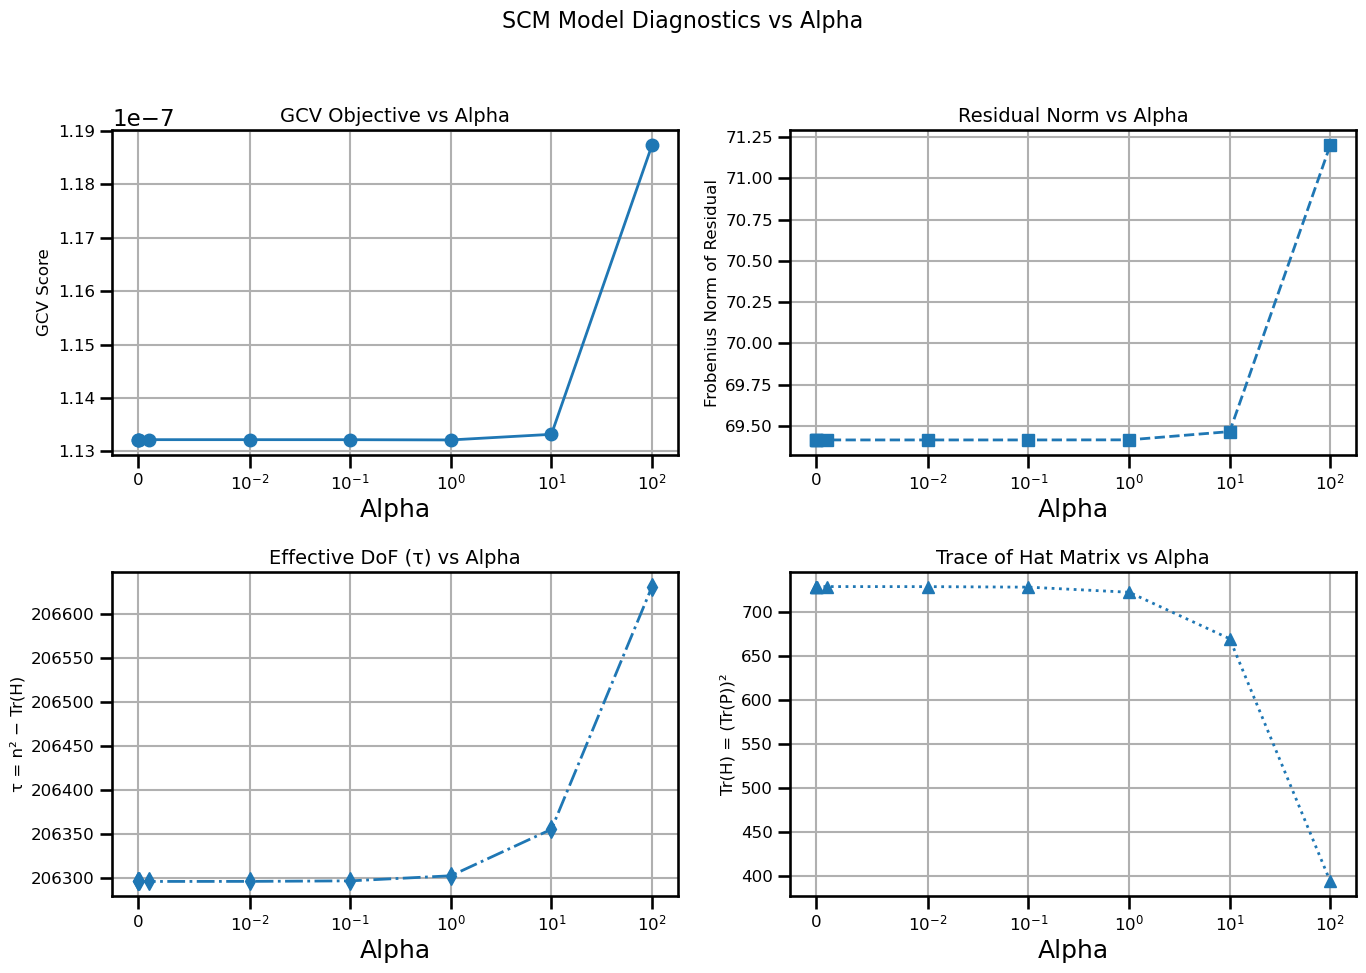

In [6]:
# # Define alpha values and run search
alphas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
results = grid_search_alpha_with_gcv(X_pca, Y, alphas)


SCM model metrics:
Pearson r: 0.560
R-squared: 0.30452
MSE: 0.02327


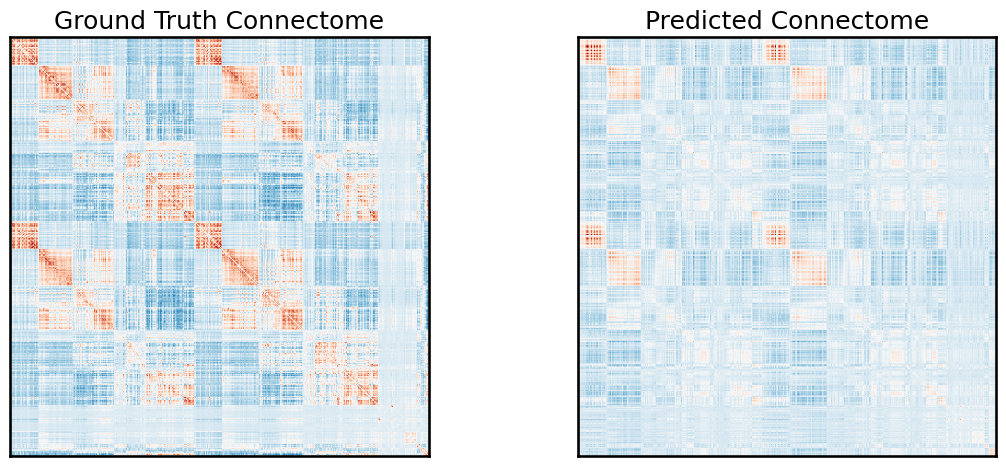

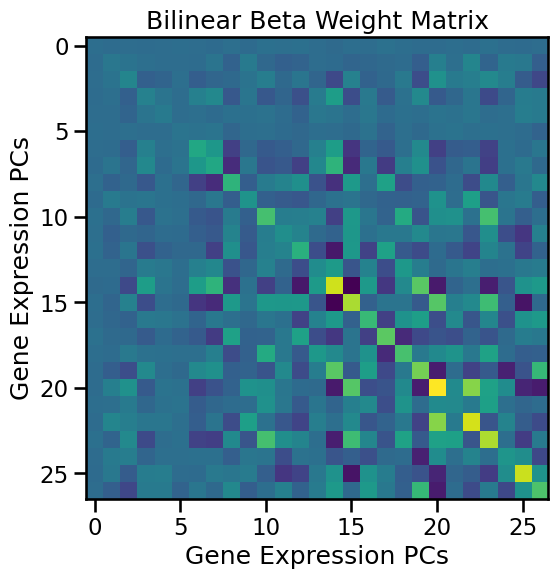

In [7]:
O, Y_pred = fit_scm_closed(X_pca, Y, alpha=0.1, plot=True)


SCM model metrics:
Pearson r: 0.560
R-squared: 0.31329
MSE: 0.02298


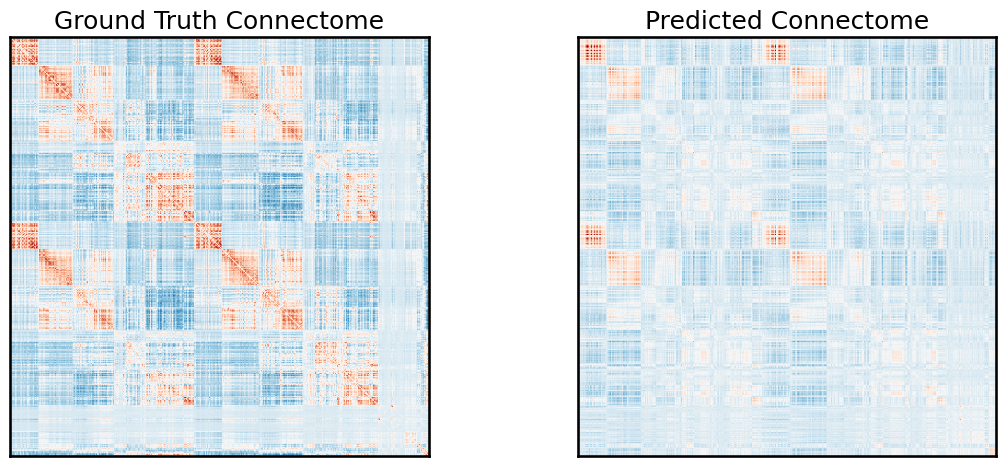

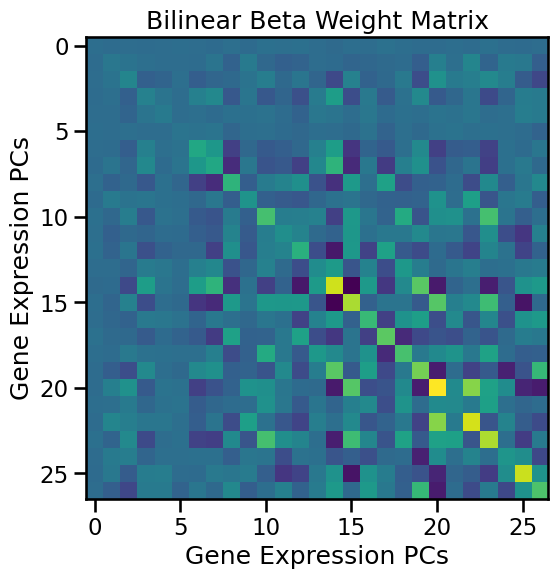

In [8]:
O, b, Y_pred = fit_scm_closed_with_scalar_bias(X_pca, Y, alpha=0.1, plot=True)

## Fit Best True PLS Model

5
10
15
20
25


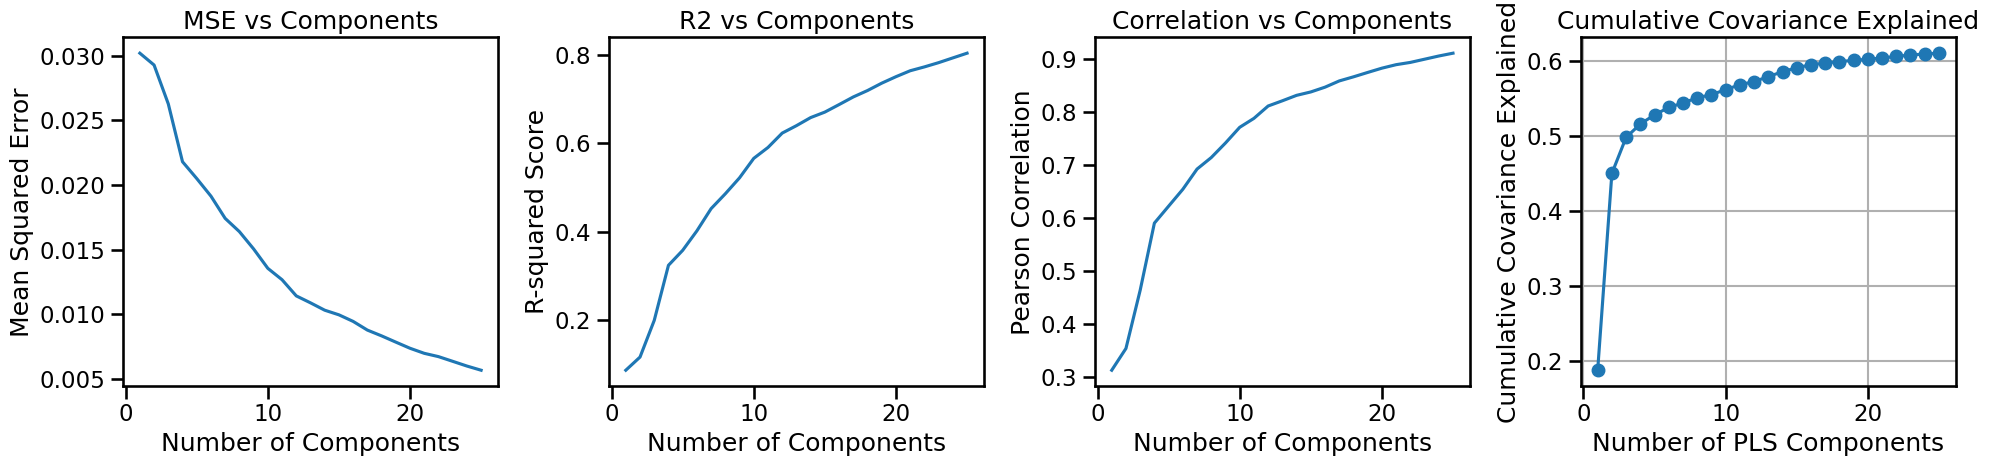

Best model performance (at elbow point):
Number of components: 9
MSE: 0.0151
R2: 0.5219
Mean correlation: 0.7416


In [17]:
best_pls_model, metrics = get_best_pls_model(X, Y, max_components=25)

## Comparison to null spin tests

In [18]:
spins_df_1k = pd.read_csv('./data/enigma/1000_null_spins.csv')
spins_df_10k = pd.read_csv('./data/enigma/10000_null_spins.csv')
spins_df_10k.head()

,cortical_spins,subcortical_spins,cortical_cost,subcortical_cost,total_cost,mean_error_rank,total_cost_rank,SA_error_rank,poly_error_rank,standardized_SA_error,...,SA_lambda_PCA,SA_inf_PCA,poly_a1,poly_a2,poly_a3,poly_a4,poly_a1_PCA,poly_a2_PCA,poly_a3_PCA,poly_a4_PCA
0,"[34, 35, 33, 102, 101, 99, 140, 152, 100, 174,...","[53, 52, 49, 51, 54, 50, 33, 34, 42, 48, 29, 4...",14676.201766,2342.839271,17019.041037,4160.000000,6710.0,678.0,5092.0,2.026880,...,39.069998,-0.164938,0.892056,-0.020372,0.000229,-7.939946e-07,0.892085,-0.026995,0.000288,-1.034092e-06
1,"[31, 33, 135, 171, 162, 154, 35, 98, 158, 101,...","[32, 55, 53, 52, 31, 51, 8, 34, 6, 54, 10, 50,...",14223.071041,3079.720650,17302.791691,8809.666667,7793.0,9389.0,9247.0,7.754004,...,18.690197,0.100440,0.895892,-0.017695,0.000150,-3.050474e-07,0.815554,-0.019567,0.000131,-1.852663e-07
2,"[165, 166, 124, 167, 114, 125, 133, 119, 113, ...","[54, 55, 32, 46, 48, 50, 3, 29, 5, 31, 30, 34,...",14066.498745,2193.130687,16259.629432,2537.333333,3951.0,1491.0,2170.0,3.195251,...,34.530601,-0.104178,0.990390,-0.023210,0.000244,-7.754920e-07,0.969185,-0.029299,0.000301,-1.024482e-06
3,"[48, 106, 110, 109, 55, 199, 179, 194, 54, 182...","[2, 55, 0, 49, 54, 50, 29, 3, 13, 51, 4, 47, 9...",13520.685713,2364.827011,15885.512724,4576.666667,2936.0,4261.0,6533.0,5.363485,...,25.958393,0.007003,0.955965,-0.020002,0.000183,-4.740132e-07,0.908789,-0.023540,0.000193,-4.967189e-07
4,"[185, 184, 64, 86, 87, 63, 85, 187, 61, 58, 56...","[4, 53, 46, 50, 28, 42, 13, 0, 34, 47, 49, 48,...",13896.760066,3108.012640,17004.772706,5959.666667,6661.0,5662.0,5556.0,6.022278,...,25.778299,0.011122,0.946094,-0.020804,0.000202,-5.556576e-07,0.959338,-0.027698,0.000260,-7.725980e-07


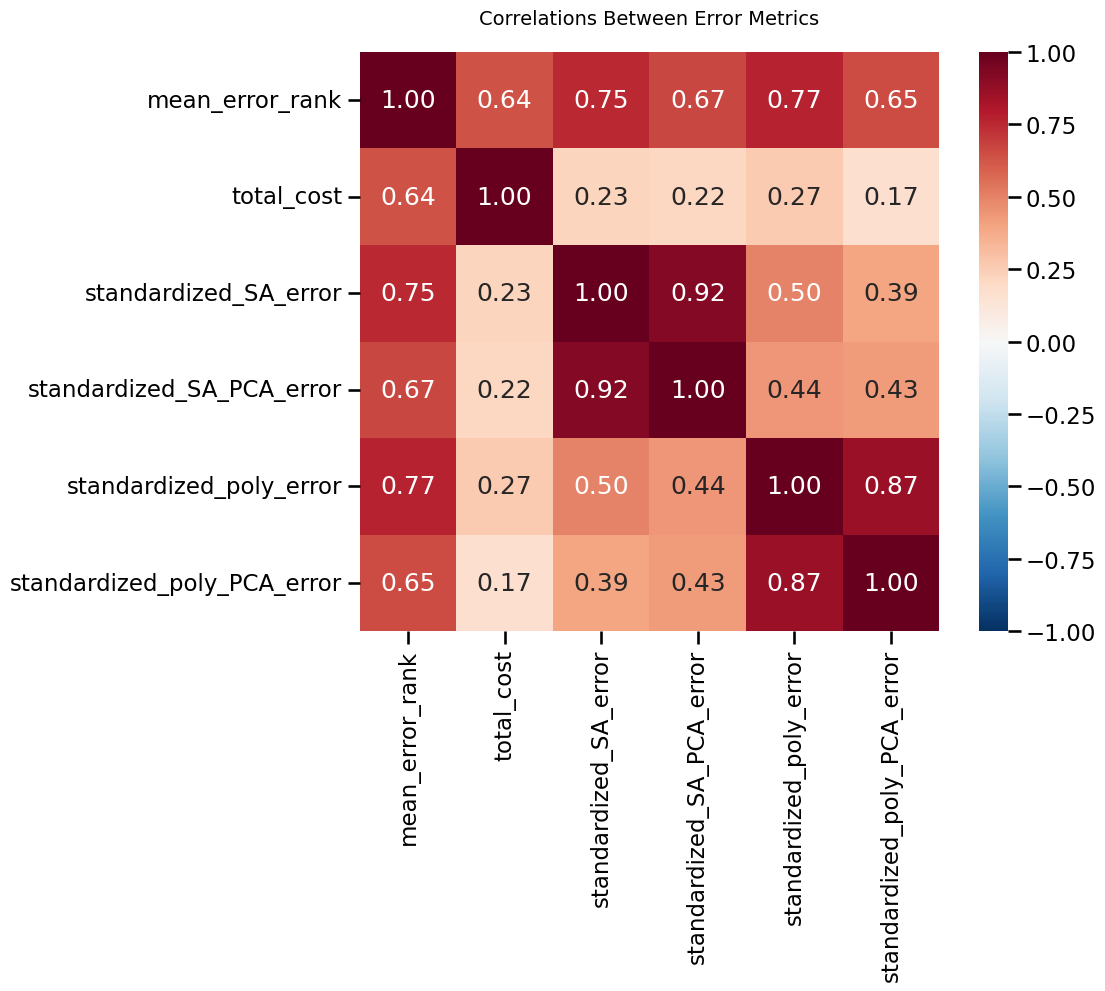

In [19]:
# Calculate correlations between error metrics
error_columns = ['mean_error_rank', 'total_cost', 'standardized_SA_error', 'standardized_SA_PCA_error', 
                'standardized_poly_error', 'standardized_poly_PCA_error']

# Compute correlation matrix
corr_matrix = spins_df_1k[error_columns].corr()

# Create figure
plt.figure(figsize=(12,10))

# Plot heatmap
sns.heatmap(corr_matrix, 
            annot=True, # Show correlation values
            cmap='RdBu_r', # Red-Blue diverging colormap
            vmin=-1, vmax=1, # Fix scale from -1 to 1
            center=0, # Center colormap at 0
            square=True, # Make cells square
            fmt='.2f') # Round correlation values to 2 decimal places

plt.title('Correlations Between Error Metrics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()




In [20]:
# Spatial null model
'''
- Idea is that autocorrelation in gene expression, X, may drive the model solution
- To address this we can generate a spatial permutation of either the gene expression data or the connectome data and refit the model
- Here we will permute the target data as in Hansen, 2021

- The spin test embodies the null hypothesis that genes and connectivity values are spatially correlated with each other because of inherent spatial autocorrelation.
- In Hansen, 2021, the P value is computed as the proportion of null singular values that are greater in magnitude than the empirical singular values.
- Thus, the P value represents the probability that the observed spatial correspondence between genes and connectivity values could occur by randomly correlating maps with comparable spatial autocorrelation

- In our case the null distribution could be the pearson-r values (or other metrics) of the best model as determined by elbow point.
'''

def run_spin_test(X, Y_true, valid_indices, spins_df, model_type='SCM', n_perms=1000, sort_spins='mean_error_rank', num_components=10):
    """
    Run spin test using precomputed spins to generate null distribution
    
    Parameters:
    -----------
    X : array-like
        Gene expression data matrix (n_regions x n_genes)
    Y_true : array-like 
        Connectivity matrix (n_regions x n_regions)
    spins_df : pandas DataFrame
        DataFrame containing precomputed spin indices
    model_type : str
        'SCM' or 'PLS' - which model to use for fitting
    n_perms : int
        Number of null permutations to run
    shuffle_target : bool
        If True, shuffle connectivity matrix, if False shuffle gene expression
        
    Returns:
    --------
    empirical_corr : float
        Correlation between true and predicted values
    p_value : float
        Spin test p-value 
    null_corrs : array
        Distribution of null correlations
    """
    
    # Sort spins_df by standardized_SA_error in ascending order
    spins_df = spins_df.sort_values(sort_spins, ascending=True)

    # Get spin indices
    cortical_spins_list = spins_df['cortical_spins'].tolist()[:n_perms]
    cortical_spins_list = [eval(x) for x in cortical_spins_list]
    cortical_spin_indices = np.array(cortical_spins_list)
    
    subcortical_spins_list = spins_df['subcortical_spins'].tolist()[:n_perms]
    subcortical_spins_list = [eval(x) for x in subcortical_spins_list]
    subcortical_spin_indices = np.array(subcortical_spins_list)

    # Fit model to true data
    if model_type == 'SCM':
        O, Y_pred = fit_scm_closed(X, Y_true)
        Y_pred_empirical = Y_pred
    else:  # PLS
        best_pls_model = PLSRegression(n_components=num_components)
        best_pls_model.fit(X, Y_true)
        Y_pred_empirical = best_pls_model.predict(X)
    
    # Calculate empirical correlation
    empirical_corr = pearsonr(Y_true.flatten(), Y_pred_empirical.flatten())[0]

    # Initialize array for null correlations
    null_corrs = np.zeros(n_perms)
    
    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
            
        # Get spin indices for this permutation
        cortical_spin_idx = cortical_spin_indices[i]
        subcortical_spin_idx = subcortical_spin_indices[i]
        
        # Shuffle gene expression
        Y_rotated = Y_true
        X_cortical_rotated = X[cortical_spin_idx]
        X_subcortical_rotated = X[subcortical_spin_idx]
        X_rotated = np.vstack([X_cortical_rotated, X_subcortical_rotated])
        X_rotated = X_rotated[valid_indices]

        # Fit model on rotated data and get predictions
        if model_type == 'SCM':
            O_null, Y_pred_null = fit_scm_closed(X_rotated, Y_rotated)
        else:  # PLS
            best_pls_model = PLSRegression(n_components=num_components)
            best_pls_model.fit(X_rotated, Y_rotated)
            Y_pred_null = best_pls_model.predict(X_rotated)
            
        null_corrs[i] = pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = np.mean(null_corrs >= empirical_corr)

    # Plot null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
    plt.axvline(empirical_corr, color='red', linestyle='--', 
                label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    plt.xlabel('Pearson correlation')
    plt.ylabel('Count')
    plt.title(f'{model_type} Spin Test Null Distribution')
    plt.legend()
    plt.show()
    
    return empirical_corr, p_value, null_corrs

permutation: 0
permutation: 50


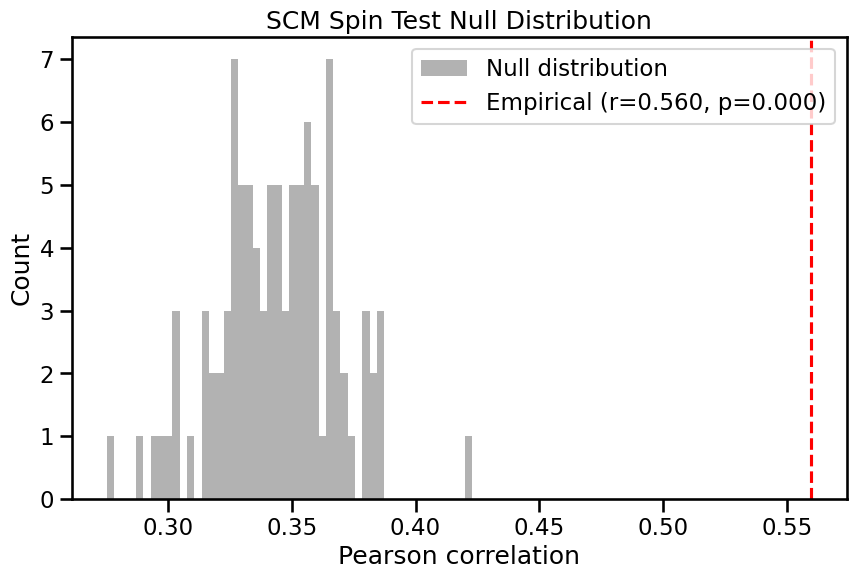

In [21]:
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_1k,
    model_type='SCM',
    sort_spins='mean_error_rank',
    n_perms=100
)

permutation: 0
permutation: 50


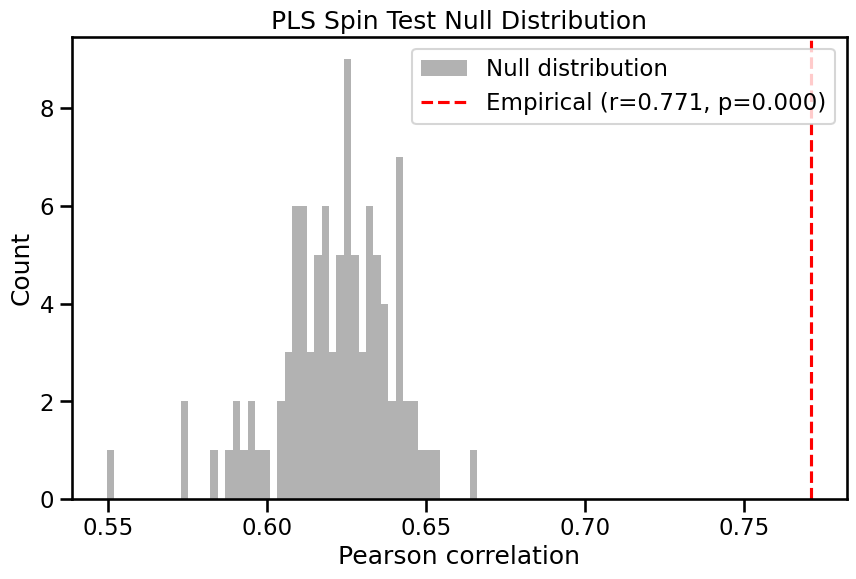

In [22]:
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_1k,
    model_type='PLS',
    num_components=10,
    sort_spins='mean_error_rank',
    n_perms=100
)

In [23]:
def run_spin_test_precomputed_colored(X, Y_true, valid_indices, spins_df, model_type='SCM', num_components=10, n_perms=1000, sort_spins='mean_error_rank', bins=25, fontsize=18):
    """
    Run spin test using precomputed spins to generate null distribution
    
    Parameters:
    -----------
    X : array-like
        Gene expression data matrix (n_regions x n_genes)
    Y_true : array-like 
        Connectivity matrix (n_regions x n_regions)
    spins_df : pandas DataFrame
        DataFrame containing precomputed spin indices
    model_type : str
        'SCM' or 'PLS' - which model to use for fitting
    num_components : int
        Number of PLS components to use (only used if model_type='PLS')
    n_perms : int
        Number of null permutations to run
    sort_spins : str
        Metric to sort spins by
    fontsize : int
        Font size for plot text elements
    """
    
    # Sort spins_df by standardized_SA_error in ascending order
    spins_df = spins_df.sort_values(sort_spins, ascending=True)

    # Get spin indices
    cortical_spins_list = spins_df['cortical_spins'].tolist()[:n_perms]
    cortical_spins_list = [eval(x) for x in cortical_spins_list]
    cortical_spin_indices = np.array(cortical_spins_list)
    
    subcortical_spins_list = spins_df['subcortical_spins'].tolist()[:n_perms]
    subcortical_spins_list = [eval(x) for x in subcortical_spins_list]
    subcortical_spin_indices = np.array(subcortical_spins_list)

    # Fit model to true data
    if model_type == 'SCM':
        O, Y_pred = fit_scm_closed(X, Y_true)
        Y_pred_empirical = Y_pred
    else:  # PLS
        best_pls_model = PLSRegression(n_components=num_components)
        best_pls_model.fit(X, Y_true)
        Y_pred_empirical = best_pls_model.predict(X)
    
    # Calculate empirical correlation
    empirical_corr = pearsonr(Y_true.flatten(), Y_pred_empirical.flatten())[0]

    # Initialize arrays for null correlations and error metrics
    null_corrs = np.zeros(n_perms)
    error_metrics = {
        'mean_error_rank': np.zeros(n_perms),
        'total_cost': np.zeros(n_perms),
        'standardized_SA_error': np.zeros(n_perms),
        'standardized_poly_error': np.zeros(n_perms),
        'standardized_SA_PCA_error': np.zeros(n_perms),
        'standardized_poly_PCA_error': np.zeros(n_perms)
    }
    
    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
          
        # Get spin indices for this permutation
        cortical_spin_idx = cortical_spin_indices[i]
        subcortical_spin_idx = subcortical_spin_indices[i]
        
        # Store error metrics for this permutation
        for metric in error_metrics.keys():
            error_metrics[metric][i] = spins_df[metric].iloc[i]
        
        # Shuffle gene expression
        Y_rotated = Y_true
        X_cortical_rotated = X[cortical_spin_idx]
        X_subcortical_rotated = X[subcortical_spin_idx]
        X_rotated = np.vstack([X_cortical_rotated, X_subcortical_rotated])
        X_rotated = X_rotated[valid_indices]

        # Fit model on rotated data
        if model_type == 'SCM':
            O_null, Y_pred_null = fit_scm_closed(X_rotated, Y_rotated)
        else:  # PLS
            best_pls_model = PLSRegression(n_components=num_components)
            best_pls_model.fit(X_rotated, Y_rotated)
            Y_pred_null = best_pls_model.predict(X_rotated)
        
        # Calculate correlation
        null_corrs[i] = pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = max(1/(n_perms + 1), np.mean(null_corrs >= empirical_corr))

    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(4, 2, figsize=(20, 18))
    axes = axes.flatten()  # Flatten for easier indexing
    
    # Plot 1: Standard uncolored histogram
    axes[0].hist(null_corrs, bins=bins, alpha=0.6, color='gray', label='Null distribution')
    axes[0].axvline(empirical_corr, color='red', linestyle='--', 
                    label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    axes[0].set_xlabel('Pearson correlation', fontsize=fontsize)
    axes[0].set_ylabel('Count', fontsize=fontsize)
    axes[0].set_title(f'Standard {model_type} Spin Test\nNull Distribution', fontsize=fontsize)
    axes[0].legend(fontsize=fontsize-2)
    axes[0].tick_params(labelsize=fontsize-2)
    
    # Calculate bin edges and centers once
    counts, bin_edges = np.histogram(null_corrs, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot colored histograms for each error metric
    for idx, (metric, values) in enumerate(error_metrics.items(), 1):
        # Calculate mean error metric for each bin
        bin_errors = np.zeros(len(bin_centers))
        for i in range(len(bin_centers)):
            mask = (null_corrs >= bin_edges[i]) & (null_corrs < bin_edges[i+1])
            bin_errors[i] = np.mean(values[mask]) if np.any(mask) else 0
        
        # Create colored histogram with darker colors for lower values
        norm = plt.Normalize(bin_errors.min(), bin_errors.max())
        colors = plt.cm.viridis(norm(bin_errors))  # Using reversed colormap
        
        # Plot bars
        bars = axes[idx].bar(bin_centers, counts, width=np.diff(bin_edges), 
                            color=colors, alpha=0.6)
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        plt.colorbar(sm, ax=axes[idx], label=metric)
        
        # Add empirical line
        axes[idx].axvline(empirical_corr, color='red', linestyle='--',
                         label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
        
        axes[idx].set_xlabel('Pearson correlation', fontsize=fontsize)
        axes[idx].set_ylabel('Count', fontsize=fontsize)
        axes[idx].set_title(f'{model_type} Spin Test Distribution\nColored by {metric}', fontsize=fontsize)
        axes[idx].legend(fontsize=fontsize-2)
        axes[idx].tick_params(labelsize=fontsize-2)
    
    plt.tight_layout()
    plt.show()
    
    return empirical_corr, p_value, null_corrs, error_metrics

In [ ]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_1k,
    model_type='SCM',
    sort_spins='mean_error_rank',
    n_perms=1000,
    bins=20
)

permutation: 0


In [ ]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='SCM',
    sort_spins='mean_error_rank',
    n_perms=1000,
    bins=20
)

In [ ]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_1k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=1000,
    bins=20
)

In [ ]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=1000,
    bins=20
)